In [1]:
import numpy as np
import pandas as pd
from fast_ml.model_development import train_valid_test_split
from string import punctuation
import re
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn.naive_bayes as naive_bayes
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivamarora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shivamarora/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('data.csv')
data = data.dropna()
print(data.shape)
data.head()

(17662, 3)


,text,speaker,label
0,Says the Annies List political group supports ...,dwayne-bohac,false
1,When did the decline of coal start? It started...,scott-surovell,half-true
2,The economic turnaround started at the end of ...,charlie-crist,half-true
3,The Chicago Bears have had more starting quart...,robin-vos,true
4,Jim Dunnam has not lived in the district he re...,republican-party-texas,barely-true


In [3]:
data['label'].value_counts()

half-true      3673
false          3464
mostly-true    3320
barely-true    2990
true           2696
pants-fire     1519
Name: label, dtype: int64

In [4]:
len(data['speaker'].unique())

5105

## Utility Functions

In [5]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in punctuation])
    return punctuationfree

In [6]:
def tokenization(text):
    return word_tokenize(str(text))

In [7]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stopWords]
    return output

In [8]:
porter_stemmer = PorterStemmer()
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

## Preprocessing

In [10]:
data.rename(columns = {'text':'content'}, inplace = True)
data.head()

,content,speaker,label
0,Says the Annies List political group supports ...,dwayne-bohac,false
1,When did the decline of coal start? It started...,scott-surovell,half-true
2,The economic turnaround started at the end of ...,charlie-crist,half-true
3,The Chicago Bears have had more starting quart...,robin-vos,true
4,Jim Dunnam has not lived in the district he re...,republican-party-texas,barely-true


In [11]:
#Punctuation Removal
data['content']= data['content'].apply(lambda x:remove_punctuation(x))

In [12]:
#Numbers Removal
remove_digits = str.maketrans('', '', digits)
data['content'] = data['content'].apply(lambda x: x.translate(remove_digits))

In [13]:
#lowering the text
data['content']= data['content'].apply(lambda x: x.lower())

In [14]:
#tokenization
data['content']= data['content'].apply(lambda x: tokenization(x))

In [15]:
#Removing stop words
data['content']= data['content'].apply(lambda x:remove_stopwords(x))

In [16]:
#Stemming
data['content']=data['content'].apply(lambda x: stemming(x))

In [17]:
#Lemmatization
data['content']=data['content'].apply(lambda x:lemmatizer(x))

In [18]:
data.head()

,content,speaker,label
0,"[say, anni, list, polit, group, support, third...",dwayne-bohac,false
1,"[declin, coal, start, start, natur, ga, took, ...",scott-surovell,half-true
2,"[econom, turnaround, start, end, term]",charlie-crist,half-true
3,"[chicago, bear, start, quarterback, last, year...",robin-vos,true
4,"[jim, dunnam, live, district, repres, year]",republican-party-texas,barely-true


In [19]:
label_map = {
    'pants-fire':0,
    'false':1,
    'barely-true':2,
    'half-true':3,
    'mostly-true':4,
    'true':5
}

In [20]:
data['label'] = data['label'].map(label_map)

In [21]:
data.head()

,content,speaker,label
0,"[say, anni, list, polit, group, support, third...",dwayne-bohac,1
1,"[declin, coal, start, start, natur, ga, took, ...",scott-surovell,3
2,"[econom, turnaround, start, end, term]",charlie-crist,3
3,"[chicago, bear, start, quarterback, last, year...",robin-vos,5
4,"[jim, dunnam, live, district, repres, year]",republican-party-texas,2


In [22]:
labelencoder = LabelEncoder()

In [23]:
data['speaker_code'] = labelencoder.fit_transform(data['speaker'])

In [24]:
data.head()

,content,speaker,label,speaker_code
0,"[say, anni, list, polit, group, support, third...",dwayne-bohac,1,3497
1,"[declin, coal, start, start, natur, ga, took, ...",scott-surovell,3,4773
2,"[econom, turnaround, start, end, term]",charlie-crist,3,3210
3,"[chicago, bear, start, quarterback, last, year...",robin-vos,5,4686
4,"[jim, dunnam, live, district, repres, year]",republican-party-texas,2,4620


## Split & Vectorization

In [25]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'label', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

In [26]:
print(y_train.value_counts())

3    2919
1    2800
4    2666
2    2377
5    2156
0    1211
Name: label, dtype: int64


In [27]:
print(y_valid.value_counts())

3    357
1    340
4    322
2    320
5    270
0    157
Name: label, dtype: int64


In [28]:
print(y_test.value_counts())

3    397
4    332
1    324
2    293
5    270
0    151
Name: label, dtype: int64


In [84]:
def identity_tokenizer(text):
    return text
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False, max_features=1000)
tfidf_vectorizer.fit(data['content'])

TfidfVectorizer(lowercase=False, max_features=1000, stop_words='english',
                tokenizer=<function identity_tokenizer at 0x7fe1bb1bc040>)

In [85]:
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train['content'])

In [86]:
tfidf_train_vectors

<14129x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 102580 stored elements in Compressed Sparse Row format>

In [87]:
tfidf_valid_vectors = tfidf_vectorizer.fit_transform(X_valid['content'])

In [88]:
tfidf_valid_vectors

<1766x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 13262 stored elements in Compressed Sparse Row format>

In [89]:
tfidf_test_vectors = tfidf_vectorizer.fit_transform(X_test['content'])

In [90]:
tfidf_test_vectors

<1767x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 13217 stored elements in Compressed Sparse Row format>

## SVM Multiclass Classification

In [91]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

In [92]:
labels = [0,1,2,3,4,5]
def plot_cm(y_true,y_pred,labels):
  cm = confusion_matrix(y_true, y_pred)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, fmt="d")
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.show()

Kernel: linear
Validation
              precision    recall  f1-score   support

           0       0.09      0.03      0.05       157
           1       0.20      0.26      0.23       340
           2       0.16      0.12      0.14       320
           3       0.22      0.27      0.24       357
           4       0.21      0.24      0.23       322
           5       0.18      0.14      0.16       270

    accuracy                           0.20      1766
   macro avg       0.18      0.18      0.17      1766
weighted avg       0.19      0.20      0.19      1766



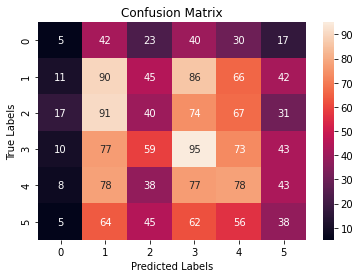


Testing
              precision    recall  f1-score   support

           0       0.09      0.06      0.07       151
           1       0.19      0.35      0.24       324
           2       0.18      0.15      0.17       293
           3       0.22      0.16      0.18       397
           4       0.21      0.21      0.21       332
           5       0.16      0.11      0.13       270

    accuracy                           0.19      1767
   macro avg       0.17      0.17      0.17      1767
weighted avg       0.18      0.19      0.18      1767



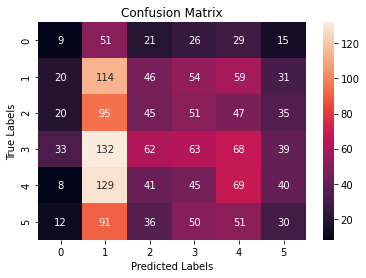

In [93]:
clf = svm.SVC(kernel='linear')
clf.fit(tfidf_train_vectors,y_train)
y_pred_valid = clf.predict(tfidf_valid_vectors)
y_pred_test = clf.predict(tfidf_test_vectors)

print('Kernel: linear')
print('Validation')
print(classification_report(y_valid,y_pred_valid))
plot_cm(y_valid,y_pred_valid,labels)
print()
print('Testing')
print(classification_report(y_test,y_pred_test))
plot_cm(y_test,y_pred_test,labels)

Kernel: rbf
Validation
              precision    recall  f1-score   support

           0       0.17      0.01      0.02       157
           1       0.21      0.30      0.25       340
           2       0.20      0.13      0.16       320
           3       0.22      0.31      0.26       357
           4       0.21      0.25      0.23       322
           5       0.21      0.15      0.18       270

    accuracy                           0.21      1766
   macro avg       0.20      0.19      0.18      1766
weighted avg       0.21      0.21      0.20      1766



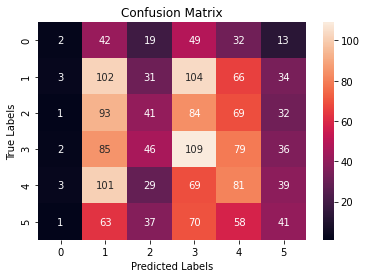


Testing
              precision    recall  f1-score   support

           0       0.11      0.02      0.03       151
           1       0.20      0.42      0.27       324
           2       0.18      0.12      0.14       293
           3       0.20      0.16      0.18       397
           4       0.21      0.22      0.21       332
           5       0.16      0.11      0.13       270

    accuracy                           0.19      1767
   macro avg       0.18      0.18      0.16      1767
weighted avg       0.18      0.19      0.18      1767



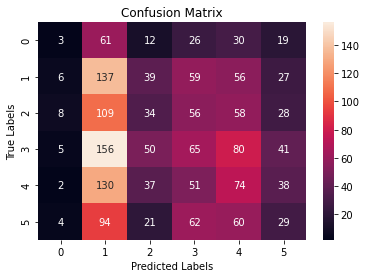

In [94]:
clf = svm.SVC(kernel='rbf')
clf.fit(tfidf_train_vectors,y_train)
y_pred_valid = clf.predict(tfidf_valid_vectors)
y_pred_test = clf.predict(tfidf_test_vectors)

print('Kernel: rbf')
print('Validation')
print(classification_report(y_valid,y_pred_valid))
plot_cm(y_valid,y_pred_valid,labels)
print()
print('Testing')
print(classification_report(y_test,y_pred_test))
plot_cm(y_test,y_pred_test,labels)

Kernel: sigmoid
Validation
              precision    recall  f1-score   support

           0       0.10      0.03      0.04       157
           1       0.20      0.26      0.22       340
           2       0.15      0.12      0.14       320
           3       0.24      0.28      0.26       357
           4       0.21      0.27      0.24       322
           5       0.18      0.14      0.16       270

    accuracy                           0.20      1766
   macro avg       0.18      0.18      0.18      1766
weighted avg       0.19      0.20      0.19      1766



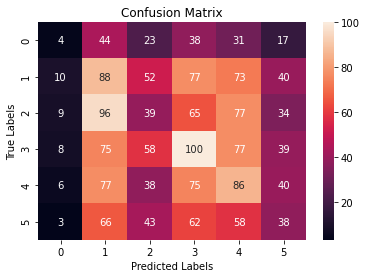


Testing
              precision    recall  f1-score   support

           0       0.09      0.06      0.07       151
           1       0.20      0.38      0.26       324
           2       0.17      0.13      0.15       293
           3       0.21      0.16      0.18       397
           4       0.22      0.22      0.22       332
           5       0.16      0.11      0.13       270

    accuracy                           0.19      1767
   macro avg       0.18      0.18      0.17      1767
weighted avg       0.19      0.19      0.18      1767



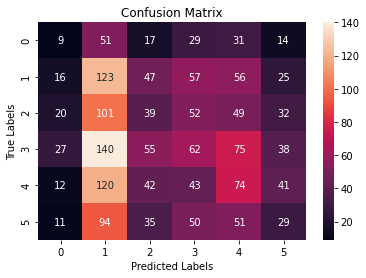

In [95]:
clf = svm.SVC(kernel='sigmoid')
clf.fit(tfidf_train_vectors,y_train)
y_pred_valid = clf.predict(tfidf_valid_vectors)
y_pred_test = clf.predict(tfidf_test_vectors)

print('Kernel: sigmoid')
print('Validation')
print(classification_report(y_valid,y_pred_valid))
plot_cm(y_valid,y_pred_valid,labels)
print()
print('Testing')
print(classification_report(y_test,y_pred_test))
plot_cm(y_test,y_pred_test,labels)

## LSTM & BiLSTM

In [41]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [42]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Input, Concatenate, TimeDistributed
from tensorflow.keras.utils import plot_model

In [43]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### LSTM - TEXT ONLY

In [96]:
model = Sequential()
model.add(Embedding(input_dim=1000, input_length=1000, output_dim=6))
model.add(Dropout(rate=0.4))
model.add(LSTM(units=4))
model.add(Dropout(rate=0.4))
model.add(Dense(units=100,  activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=6, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1000, 6)           6000      
                                                                 
 dropout_13 (Dropout)        (None, 1000, 6)           0         
                                                                 
 lstm_7 (LSTM)               (None, 4)                 176       
                                                                 
 dropout_14 (Dropout)        (None, 4)                 0         
                                                                 
 dense_6 (Dense)             (None, 100)               500       
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                

In [98]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [99]:
history = model.fit(
    tfidf_train_vectors.toarray(), 
    y_train, 
    validation_data=[tfidf_valid_vectors.toarray(), y_valid],
    epochs = 5
)

Epoch 1/5
442/442 [==============================] - 122s 269ms/step - loss: 1.7653 - accuracy: 0.1999 - val_loss: 1.7631 - val_accuracy: 0.2022
Epoch 2/5
442/442 [==============================] - 112s 253ms/step - loss: 1.7606 - accuracy: 0.2022 - val_loss: 1.7636 - val_accuracy: 0.2022
Epoch 3/5
442/442 [==============================] - 107s 242ms/step - loss: 1.7598 - accuracy: 0.1999 - val_loss: 1.7638 - val_accuracy: 0.2022
Epoch 4/5
442/442 [==============================] - 111s 251ms/step - loss: 1.7599 - accuracy: 0.2043 - val_loss: 1.7635 - val_accuracy: 0.2022
Epoch 5/5
442/442 [==============================] - 109s 246ms/step - loss: 1.7591 - accuracy: 0.2079 - val_loss: 1.7640 - val_accuracy: 0.2022


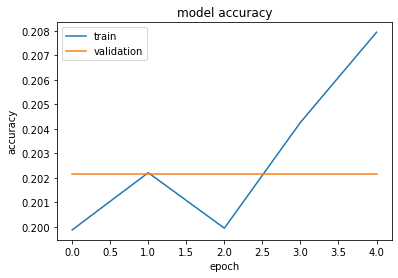

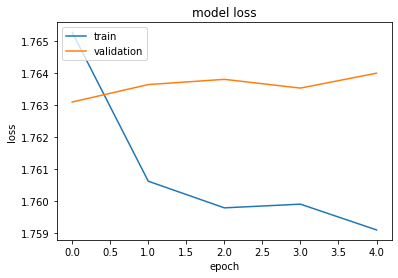

In [100]:
plot_history(history)

In [101]:
score, acc = model.evaluate(tfidf_test_vectors.toarray(), y_test)
print('Test score:', score)
print('Test accuracy:', acc)

56/56 [==============================] - 3s 48ms/step - loss: 1.7568 - accuracy: 0.2247
Test score: 1.756770133972168
Test accuracy: 0.22467458248138428


In [102]:
y_probas = model.predict(tfidf_test_vectors.toarray())
y_pred = y_probas.argmax(axis=-1)

56/56 [==============================] - 3s 47ms/step


In [103]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       151
           1       1.00      0.00      0.00       324
           2       1.00      0.00      0.00       293
           3       0.22      1.00      0.37       397
           4       1.00      0.00      0.00       332
           5       1.00      0.00      0.00       270

    accuracy                           0.22      1767
   macro avg       0.87      0.17      0.06      1767
weighted avg       0.83      0.22      0.08      1767



### Bi-LSTM - TEXT ONLY

In [104]:
model = Sequential()
model.add(Embedding(input_dim=1000, input_length=1000, output_dim=6))
model.add(Dropout(rate=0.4))
model.add(Bidirectional(LSTM(units=4)))
model.add(Dropout(rate=0.4))
model.add(Dense(units=100,  activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=6, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1000, 6)           6000      
                                                                 
 dropout_16 (Dropout)        (None, 1000, 6)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 8)                352       
 nal)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 100)               900       
                                                                 
 dropout_18 (Dropout)        (None, 100)               0         
                                                      

In [105]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


In [106]:
history = model.fit(
    tfidf_train_vectors.toarray(), 
    y_train, 
    validation_data=[tfidf_valid_vectors.toarray(), y_valid],
    epochs = 5
)

Epoch 1/5
442/442 [==============================] - 161s 348ms/step - loss: 1.7650 - accuracy: 0.1998 - val_loss: 1.7635 - val_accuracy: 0.2022
Epoch 2/5
442/442 [==============================] - 141s 319ms/step - loss: 1.7601 - accuracy: 0.2053 - val_loss: 1.7635 - val_accuracy: 0.2022
Epoch 3/5
442/442 [==============================] - 130s 295ms/step - loss: 1.7599 - accuracy: 0.2046 - val_loss: 1.7639 - val_accuracy: 0.2022
Epoch 4/5
442/442 [==============================] - 137s 309ms/step - loss: 1.7592 - accuracy: 0.2062 - val_loss: 1.7635 - val_accuracy: 0.2022
Epoch 5/5
442/442 [==============================] - 128s 289ms/step - loss: 1.7601 - accuracy: 0.2048 - val_loss: 1.7636 - val_accuracy: 0.1925


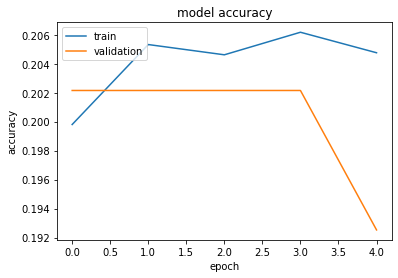

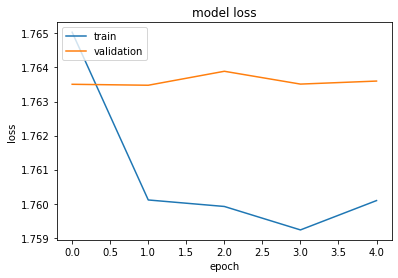

In [107]:
plot_history(history)

In [108]:
score, acc = model.evaluate(tfidf_test_vectors.toarray(), y_test)
print('Test score:', score)
print('Test accuracy:', acc)

56/56 [==============================] - 3s 48ms/step - loss: 1.7586 - accuracy: 0.1834
Test score: 1.7586222887039185
Test accuracy: 0.18336163461208344


In [109]:
y_probas = model.predict(tfidf_test_vectors.toarray())
y_pred = y_probas.argmax(axis=-1)

56/56 [==============================] - 3s 47ms/step


In [110]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       151
           1       0.18      1.00      0.31       324
           2       0.00      0.00      0.00       293
           3       0.00      0.00      0.00       397
           4       0.00      0.00      0.00       332
           5       0.00      0.00      0.00       270

    accuracy                           0.18      1767
   macro avg       0.03      0.17      0.05      1767
weighted avg       0.03      0.18      0.06      1767



### LSTM - Text & Publisher

In [111]:
publisher_train = X_train['speaker_code']
publisher_valid = X_valid['speaker_code']
publisher_test = X_test['speaker_code']

In [112]:
publisher_train

1559     2917
15094     839
6773     3479
693      3468
3951     3202
         ... 
14296    1384
16734     174
17524     874
355      4429
566      3683
Name: speaker_code, Length: 14129, dtype: int64

In [113]:
publisher_input = Input(shape=(1,))
publisher_features = (Embedding(input_dim=5105, input_length=1, output_dim=1000))(publisher_input)
publisher_features = Dropout(rate=0.4)(publisher_features)
publisher_features = LSTM(units=4)(publisher_features)

In [114]:
text_input = Input(shape=(1000,))
text_features = (Embedding(input_dim=1000, input_length=1000, output_dim=1000))(text_input)
text_features = Dropout(rate=0.4)(text_features)
text_features = LSTM(units=4)(text_features)

In [115]:
x = Concatenate()([publisher_features, text_features])
x = Dropout(rate=0.5)(x)
model_output = Dense(units=6, activation='sigmoid')(x)

model = Model([publisher_input, text_input], model_output, name='model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 1, 1000)      5105000     ['input_6[0][0]']                
                                                                                                  
 embedding_10 (Embedding)       (None, 1000, 1000)   1000000     ['input_7[0][0]']                
                                                                                              

In [116]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [117]:
history = model.fit(
    [publisher_train, tfidf_train_vectors.toarray()], 
    y_train, 
    validation_data=[[publisher_valid, tfidf_valid_vectors.toarray()], y_valid],
    epochs = 5
)

Epoch 1/5
442/442 [==============================] - 422s 944ms/step - loss: 1.7616 - accuracy: 0.2043 - val_loss: 1.7463 - val_accuracy: 0.2095
Epoch 2/5
442/442 [==============================] - 451s 1s/step - loss: 1.7077 - accuracy: 0.2564 - val_loss: 1.7422 - val_accuracy: 0.2225
Epoch 3/5
442/442 [==============================] - 432s 976ms/step - loss: 1.6463 - accuracy: 0.3048 - val_loss: 1.7546 - val_accuracy: 0.2044
Epoch 4/5
442/442 [==============================] - 421s 951ms/step - loss: 1.5930 - accuracy: 0.3308 - val_loss: 1.7671 - val_accuracy: 0.2123
Epoch 5/5
442/442 [==============================] - 406s 918ms/step - loss: 1.5378 - accuracy: 0.3548 - val_loss: 1.7868 - val_accuracy: 0.2157


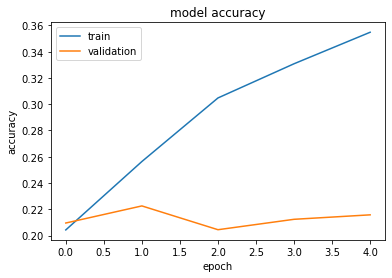

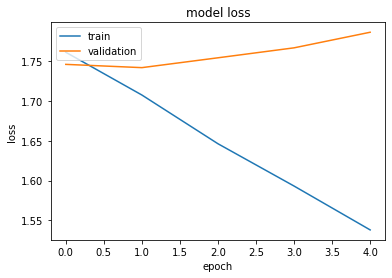

In [118]:
plot_history(history)

In [119]:
score, acc = model.evaluate([publisher_test ,tfidf_test_vectors.toarray()], y_test)
print('Test score:', score)
print('Test accuracy:', acc)

56/56 [==============================] - 13s 230ms/step - loss: 1.7712 - accuracy: 0.2269
Test score: 1.7711611986160278
Test accuracy: 0.22693830728530884


In [120]:
y_probas = model.predict([publisher_test, tfidf_test_vectors.toarray()])
y_pred = y_probas.argmax(axis=-1)

56/56 [==============================] - 14s 229ms/step


In [121]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.44      0.17      0.25       151
           1       0.22      0.34      0.27       324
           2       0.15      0.10      0.12       293
           3       0.21      0.22      0.22       397
           4       0.24      0.38      0.29       332
           5       0.24      0.09      0.13       270

    accuracy                           0.23      1767
   macro avg       0.25      0.22      0.21      1767
weighted avg       0.23      0.23      0.21      1767



### BiLSTM - Text & Publisher

In [122]:
publisher_input = Input(shape=(1,))
publisher_features = (Embedding(input_dim=5105, input_length=1, output_dim=1000))(publisher_input)
publisher_features = Dropout(rate=0.4)(publisher_features)
publisher_features = Bidirectional(LSTM(units=4))(publisher_features)

In [123]:
text_input = Input(shape=(1000,))
text_features = (Embedding(input_dim=1000, input_length=1000, output_dim=1000))(text_input)
text_features = Dropout(rate=0.4)(text_features)
text_features = Bidirectional(LSTM(units=4))(text_features)

In [124]:
x = Concatenate()([publisher_features, text_features])
x = Dropout(rate=0.5)(x)
model_output = Dense(units=6, activation='sigmoid')(x)

model = Model([publisher_input, text_input], model_output, name='model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 1, 1000)      5105000     ['input_8[0][0]']                
                                                                                                  
 embedding_12 (Embedding)       (None, 1000, 1000)   1000000     ['input_9[0][0]']                
                                                                                              

In [125]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [126]:
history = model.fit(
    [publisher_train, tfidf_train_vectors.toarray()], 
    y_train, 
    validation_data=[[publisher_valid, tfidf_valid_vectors.toarray()], y_valid],
    epochs = 5
)

Epoch 1/5
442/442 [==============================] - 587s 1s/step - loss: 1.7546 - accuracy: 0.2142 - val_loss: 1.7371 - val_accuracy: 0.2203
Epoch 2/5
442/442 [==============================] - 573s 1s/step - loss: 1.6823 - accuracy: 0.2944 - val_loss: 1.7374 - val_accuracy: 0.2327
Epoch 3/5
442/442 [==============================] - 591s 1s/step - loss: 1.5732 - accuracy: 0.3827 - val_loss: 1.7684 - val_accuracy: 0.2350
Epoch 4/5
442/442 [==============================] - 588s 1s/step - loss: 1.4874 - accuracy: 0.4126 - val_loss: 1.8186 - val_accuracy: 0.2282
Epoch 5/5
442/442 [==============================] - 537s 1s/step - loss: 1.4174 - accuracy: 0.4324 - val_loss: 1.8600 - val_accuracy: 0.2129


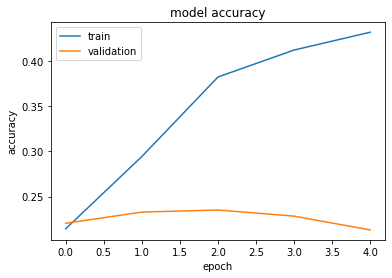

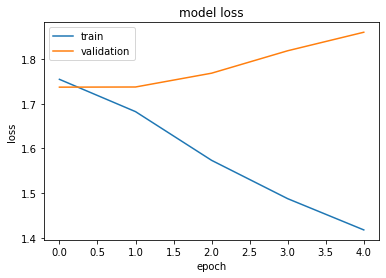

In [127]:
plot_history(history)

In [128]:
score, acc = model.evaluate([publisher_test ,tfidf_test_vectors.toarray()], y_test)
print('Test score:', score)
print('Test accuracy:', acc)

56/56 [==============================] - 15s 272ms/step - loss: 1.8520 - accuracy: 0.2383
Test score: 1.8519994020462036
Test accuracy: 0.23825693130493164


In [130]:
y_probas = model.predict([publisher_test, tfidf_test_vectors.toarray()])
y_pred = y_probas.argmax(axis=-1)

56/56 [==============================] - 16s 271ms/step


In [131]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.43      0.19      0.27       151
           1       0.24      0.41      0.30       324
           2       0.19      0.10      0.13       293
           3       0.24      0.29      0.26       397
           4       0.23      0.24      0.23       332
           5       0.23      0.12      0.16       270

    accuracy                           0.24      1767
   macro avg       0.26      0.23      0.23      1767
weighted avg       0.24      0.24      0.23      1767

